In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# # loss 그래프 시각화
# def plot_learning_curves(loss):
#     plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
#     # plt.plot(np.arange(len(accuracy)) + 1, accuracy, "r.-", label="Accuracy")
#     plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.5])
#     plt.legend(fontsize=14)
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.grid(True)
# plot_learning_curves(history.history["loss"])
# plt.title("Autoencoder_adam")
# plt.show()

#### Undercomplete Autoencoder부터 시작

In [2]:
# 파이값을 사용해서 임의로 함수 제작
def generate_3d_data(m, w1, w2, noise):
  angles = np.random.rand(m)*4*np.pi/2
  data = np.empty((m,3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
  data[:, 1] = np.sin(angles) + 0.7 + noise * np.random.randn(m) / 2
  data[:, 2] = data[:, 0]*w1 + data[:, 1] *w2 + noise * np.random.randn(m)
  return data

X_train = generate_3d_data(60, 0.1, 0.3, 0.1)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
# 확인
X_train[0:10]

array([[ 0.51326483,  1.18275611,  0.47110653],
       [-0.42507644, -0.81946982, -0.25674517],
       [-0.96275413, -0.2807058 , -0.13012079],
       [-0.9678464 ,  0.05520274, -0.15881238],
       [ 1.24912408,  0.64624571,  0.21680245],
       [ 0.35016729, -0.60146331,  0.00181805],
       [ 1.23627409,  0.47462187,  0.3355077 ],
       [ 0.45104418, -0.5401615 ,  0.0190042 ],
       [-0.88926335,  0.20193065, -0.08857283],
       [-1.00631064, -0.44779124, -0.1834594 ]])

In [ ]:
# autoencoder 모델

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
optimizer = keras.optimizers.SGD(learning_rate=1.5, decay=0.001)

In [ ]:
# autoencoder 컴파일, 최적화 = sgd부터 실험
autoencoder.compile(loss="mse", optimizer = optimizer)

In [ ]:
# 학습 시작
# 30회
history = autoencoder.fit(X_train, X_train, epochs=30, callbacks = tqdm_callback)

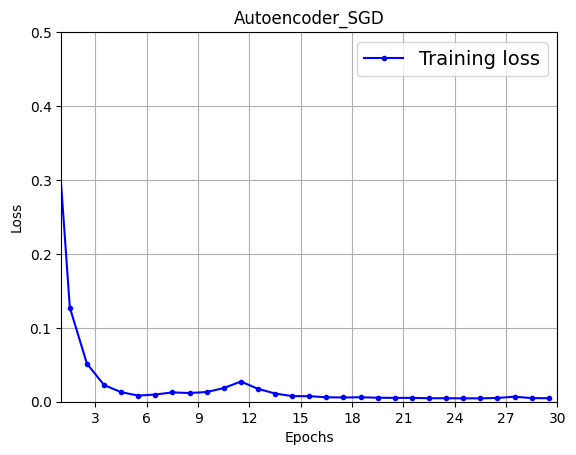

In [ ]:
# loss 그래프 시각화
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(accuracy)) + 1, accuracy, "r.-", label="Accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"])
plt.title("Autoencoder_SGD")
plt.show()

In [ ]:
# 코딩
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 7ms/step


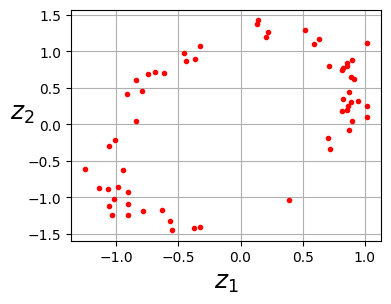

In [ ]:
# 2D 사이즈에 인코딩
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "r.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

#### Stacked autoencoder 로드

In [3]:
# MNIST 데이터셋
(X_train, y_train), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
# 검증셋, 훈련셋 분리
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_valid = y_train[:-5000], y_train[-5000:]

In [5]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true) , tf.round(y_pred))

In [7]:
# stacked 모델
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = "selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation = "sigmoid"),
    keras.layers.Reshape([28, 28]),
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [8]:
# 오토인코더 컴파일 - mse 실험
optimizer = keras.optimizers.Nadam()
stacked_ae.compile(loss="mse", optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 학습 시작
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid), callbacks =tqdm_callback)

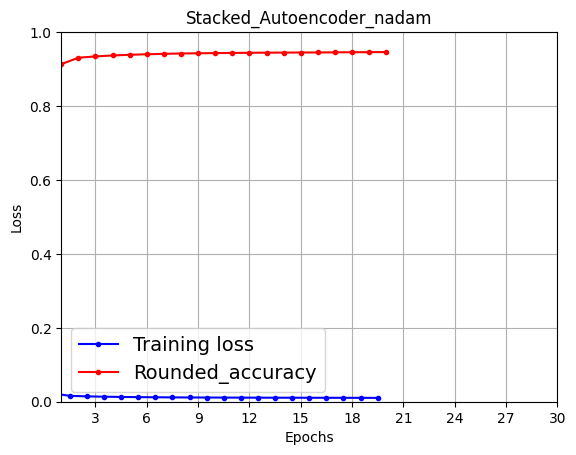

In [ ]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="Rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"])
plt.title("Stacked_Autoencoder_nadam")
plt.show()

1/1 [==============================] - 0s 42ms/step


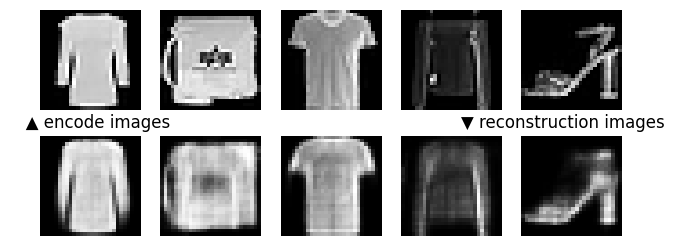

In [ ]:
# 테스트 이미지 정의 함수
def plot_image(image):
  plt.imshow(image, cmap="gray")
  plt.axis("off")
def show_reconstructions(model, images = X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    if image_index == 1:
      plt.title("   ▲ encode images")
    plt.subplot(2, n_images, 1+image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1+n_images + image_index)
    plot_image(reconstructions[image_index])
  plt.title("▼ reconstruction images   ")
show_reconstructions(stacked_ae)

#### 그 외 시각화

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
# TSNE > t분산 스토캐스틱 이웃 근접 사용. 변환
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


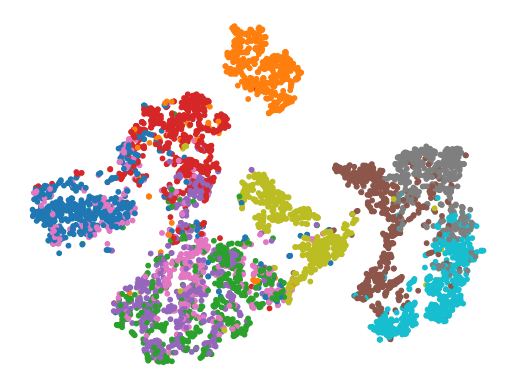

In [ ]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:, 1], c = y_valid, s = 10, cmap="tab10")
plt.axis("off")
plt.show()

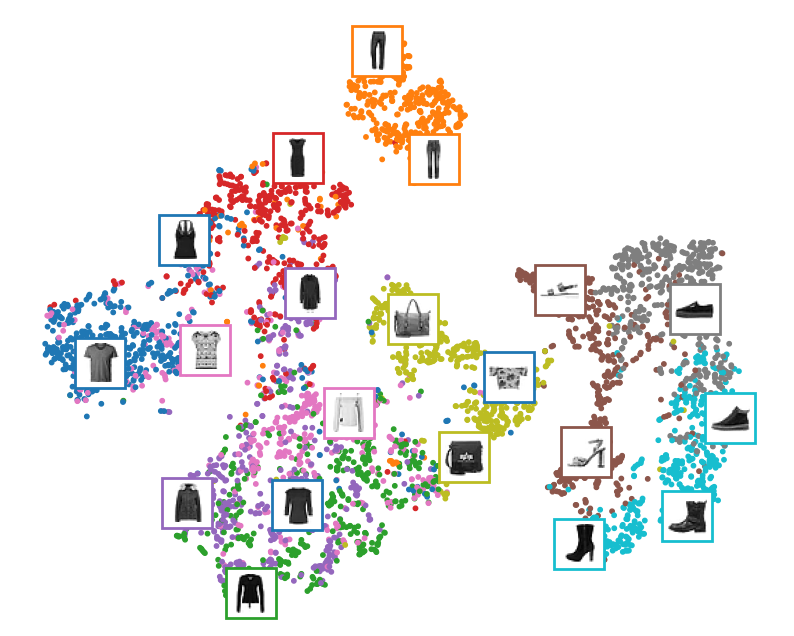

In [ ]:
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Stacked Autoencoder를 통한 가중치 집합

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
# 모델 정의
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, activation = "selu")
dense_2 = keras.layers.Dense(30, activation = "selu")
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [ ]:
# 오토인코더 컴파일 - nadam 실험
optimizer = keras.optimizers.Nadam()
stacked_ae.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 학습 시작
history = stacked_ae.fit(X_train, X_train, epochs=30,
                         validation_data=(X_valid, X_valid), callbacks =tqdm_callback)

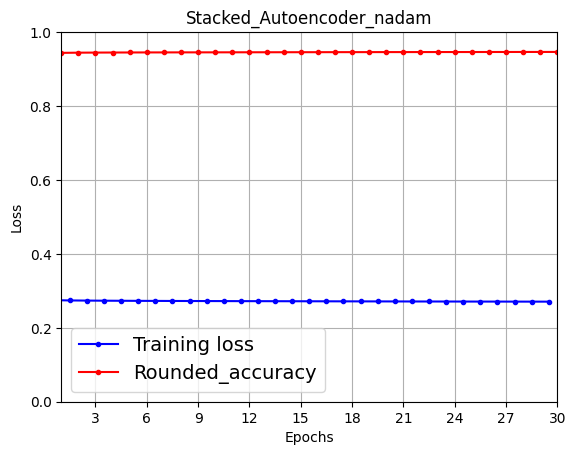

In [ ]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="Rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"])
plt.title("Stacked_Autoencoder_nadam")
plt.show()

1/1 [==============================] - 0s 32ms/step


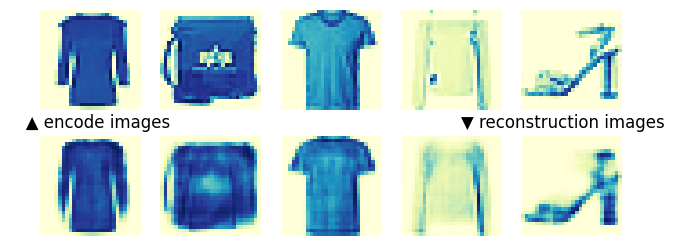

In [ ]:
# 테스트 이미지 정의 함수
def plot_image(image):
  plt.imshow(image, cmap="YlGnBu")
  plt.axis("off")
def show_reconstructions(model, images = X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    if image_index == 1:
      plt.title("   ▲ encode images")
    plt.subplot(2, n_images, 1+image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1+n_images + image_index)
    plot_image(reconstructions[image_index])
  plt.title("▼ reconstruction images   ")
show_reconstructions(stacked_ae)

157/157 [==============================] - 0s 2ms/step


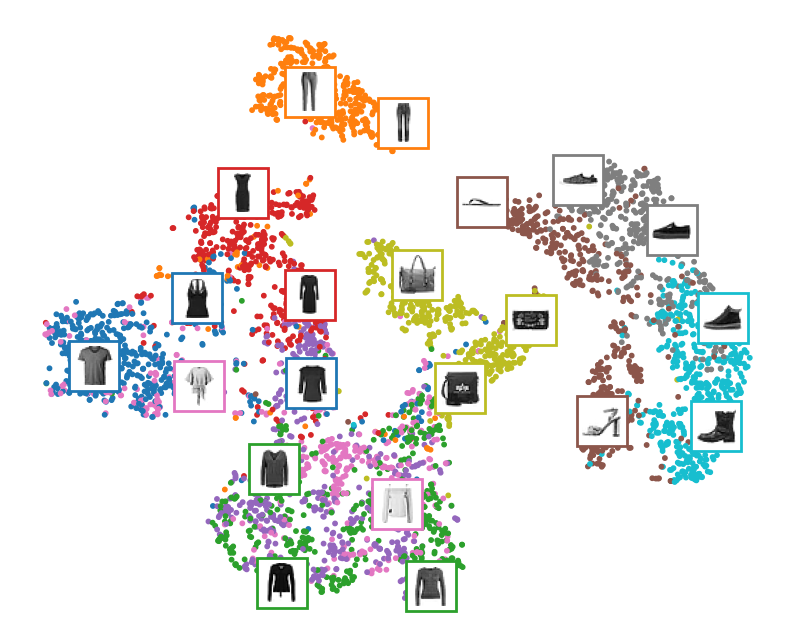

In [ ]:
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
# 한번에 하나의 오토 인코더 훈련
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs,
                      output_activation, metrics):
  n_inputs = X_train.shape[-1]
  encoder = keras.models.Sequential([
      keras.layers.Dense(n_neurons, activation = "selu", input_shape=[n_inputs])
  ])
  decoder = keras.models.Sequential([
      keras.layers.Dense(n_inputs, activation = output_activation),
  ])
  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(optimizer, loss, metrics=metrics)
  history = autoencoder.fit(X_train, X_train, epochs = n_epochs,
                  validation_data = (X_valid, X_valid), callbacks = tqdm_callback)
  return encoder, decoder, encoder(X_train), encoder(X_valid)


In [ ]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy", optimizer=optimizer,
    n_epochs = 20, output_activation = "sigmoid", metrics=[rounded_accuracy]
)

157/157 [==============================] - 0s 1ms/step


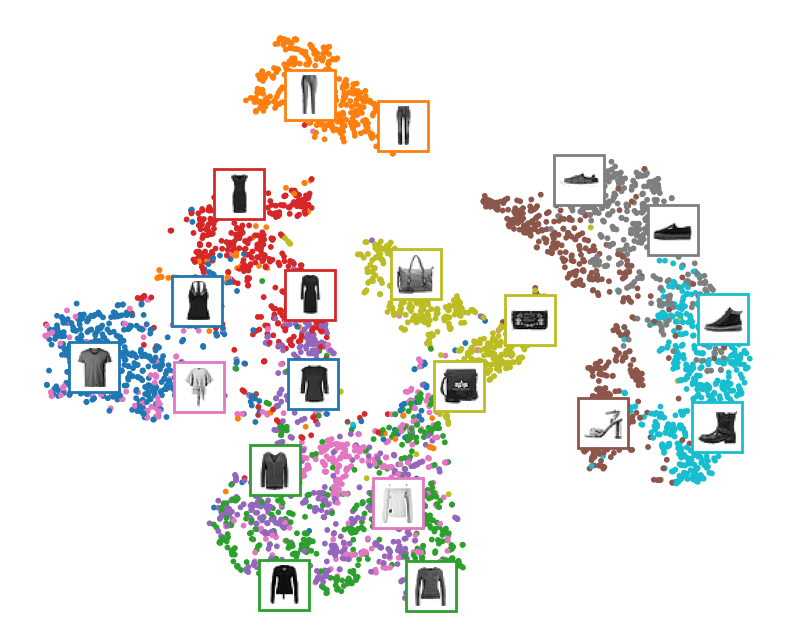

In [ ]:
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
# loss함수 mse로 변경, activation selu로 변경
optimizer =  keras.optimizers.SGD(learning_rate=0.05)
enc2, dec2, _, _ = train_autoencoder(
    40, X_train_enc1, X_valid_enc1, "mse", optimizer=optimizer,
    n_epochs = 20,
    output_activation="selu",
    metrics=[rounded_accuracy]
)

1/1 [==============================] - 0s 68ms/step


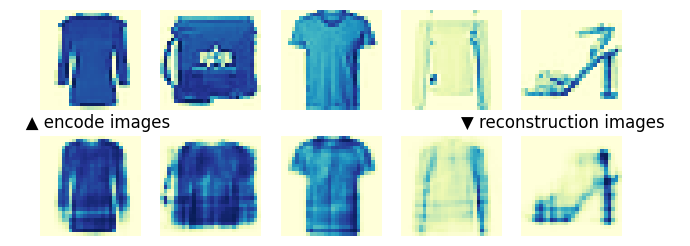

In [ ]:
# 최종 적층 오토인코더
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])
show_reconstructions(stacked_ae_1_by_1)
plt.show()

157/157 [==============================] - 0s 1ms/step


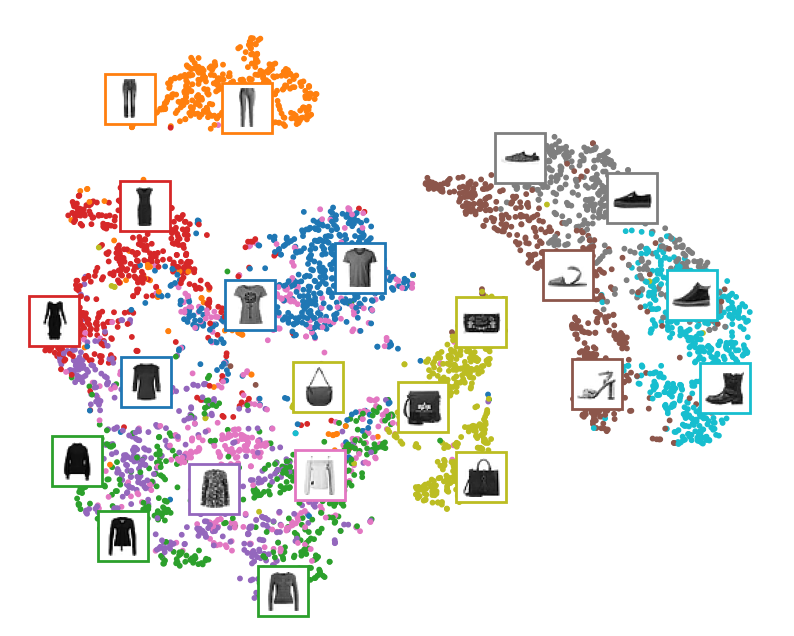

In [ ]:
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
# 모델 컴파일
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 모델학습 30회
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=30,
                                validation_data=(X_valid, X_valid), callbacks = tqdm_callback)

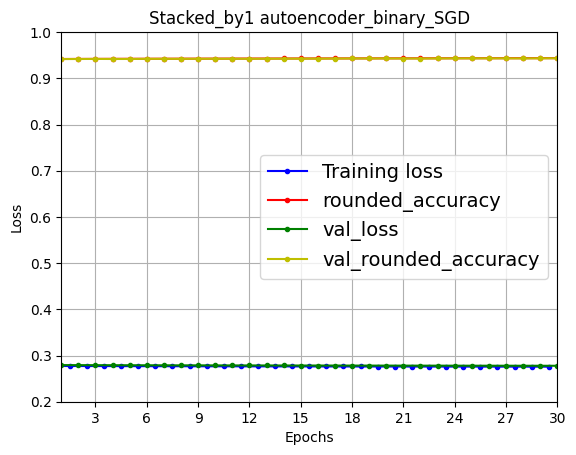

In [ ]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy, val_loss,val_rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="rounded_accuracy")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "g.-", label="val_loss")
    plt.plot(np.arange(len(val_rounded_accuracy)) + 1, val_rounded_accuracy, "y.-", label="val_rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0.2, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"],
                     history.history["val_loss"], history.history["val_rounded_accuracy"])
plt.title("Stacked_by1 autoencoder_binary_SGD")
plt.show()

1/1 [==============================] - 0s 31ms/step


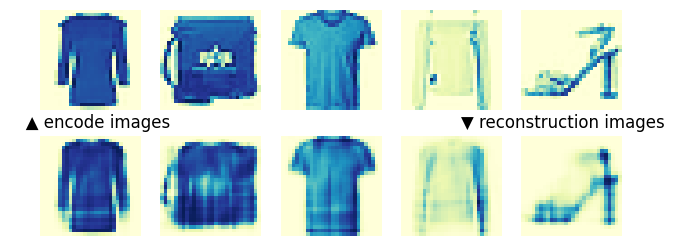

In [ ]:
# 모델 학습 후 디코딩 사진
show_reconstructions(stacked_ae_1_by_1)
plt.show()

#### Convolution Autoencoder 로드

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size = 3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size = 3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size = 3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size = 3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size = 3, strides=2,padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size = 3,strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])
conv_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
# 컴파일
optimizer =  keras.optimizers.SGD(learning_rate=1.0)
conv_autoencoder.compile(loss="binary_crossentropy",
                          optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 모델 학습 20회
history = conv_autoencoder.fit(X_train, X_train, epochs=30,
                         validation_data=(X_valid, X_valid), callbacks =tqdm_callback)

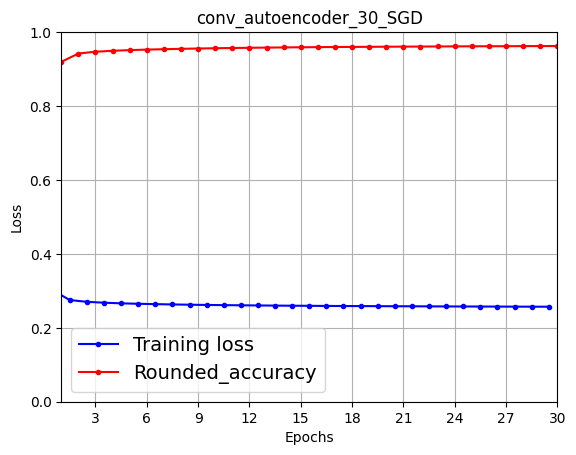

In [ ]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="Rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0.2, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"])
plt.title("conv_autoencoder_30_SGD")
plt.show()

In [14]:
# 테스트 이미지 정의 함수
def plot_image(image):
  plt.imshow(image, cmap="YlGnBu")
  plt.axis("off")
def show_reconstructions(model, images = X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    if image_index == 1:
      plt.title("   ▲ encode images")
    plt.subplot(2, n_images, 1+image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1+n_images + image_index)
    plot_image(reconstructions[image_index])
  plt.title("▼ reconstruction images   ")
show_reconstructions(conv_autoencoder)


#### Recurrent Autoencoder
- 동일한 MNIST 데이터 사용

In [9]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences = True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
# 벡터 to 시퀸스 RNN
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])


In [10]:
# recurrent ae 컴파일
recurrent_ae.compile(loss="binary_crossentropy", optimizer = optimizer,
                      metrics=[rounded_accuracy])

In [ ]:
# 학습 시작
history = recurrent_ae.fit(X_train, X_train, epochs=20, validation_data = (X_valid, X_valid), callbacks = tqdm_callback)

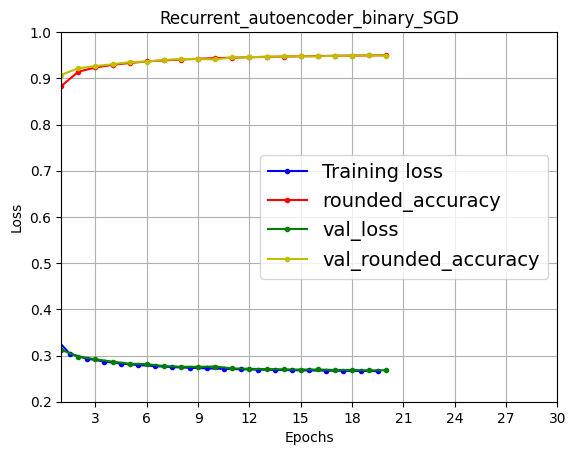

In [12]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy, val_loss,val_rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="rounded_accuracy")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "g.-", label="val_loss")
    plt.plot(np.arange(len(val_rounded_accuracy)) + 1, val_rounded_accuracy, "y.-", label="val_rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0.2, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"],
                     history.history["val_loss"], history.history["val_rounded_accuracy"])
plt.title("Recurrent_autoencoder_binary_SGD")
plt.show()

1/1 [==============================] - 1s 1s/step


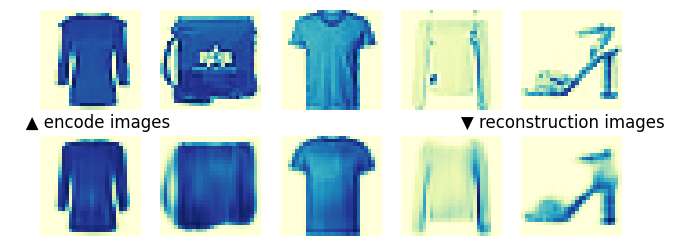

In [15]:
# 모델 학습 후 디코딩 사진
show_reconstructions(recurrent_ae)
plt.show()

#### Stacked denoising autoencoder
> 가우시안 noise를 사용한 stacked denoising

In [16]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [17]:
# 모델
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [18]:
# 모델 컴파일
optimizer = keras.optimizers.SGD(learning_rate=1.0)
denoising_ae.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=[rounded_accuracy])

In [ ]:
# 학습 10회
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid), callbacks=tqdm_callback)

1/1 [==============================] - 0s 70ms/step


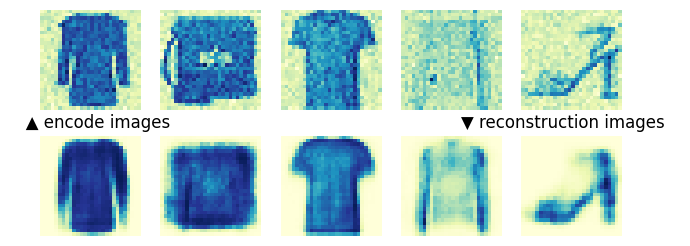

In [20]:
# 노이즈 추가 후 디코딩 사진
noise = keras.layers.GaussianNoise(0.1)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [21]:
# 드롭아웃 적용한 디노이징 오토인코더
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [22]:
# 모델 컴파일
optimizer = keras.optimizers.SGD(learning_rate=1.0)
denoising_ae.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=[rounded_accuracy])

In [ ]:
# 학습 10회
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid), callbacks=tqdm_callback)

1/1 [==============================] - 0s 43ms/step


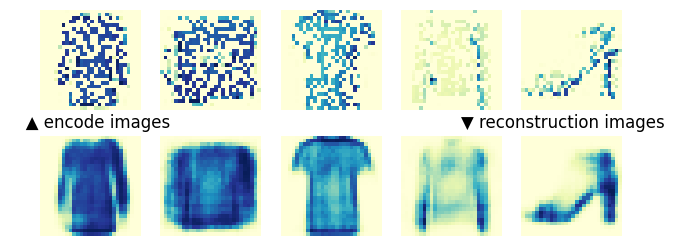

In [28]:
# 드롭아웃까지 추가 후 디코딩 사진
dropout = keras.layers.Dropout(0.5)
show_reconstructions(denoising_ae, dropout(X_valid, training=True))
plt.show()